.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 398481/400000 [00:29<00:00, 27001.46it/s]

	Train Loss: 0.693 | Train Acc: 52.58%
	Train Loss: 0.693 | Train Acc: 51.36%
	Train Loss: 0.689 | Train Acc: 52.95%
	Train Loss: 0.692 | Train Acc: 51.60%
	Train Loss: 0.693 | Train Acc: 50.21%
	Train Loss: 0.691 | Train Acc: 52.40%
	Train Loss: 0.682 | Train Acc: 57.36%
	Train Loss: 0.681 | Train Acc: 56.33%
	Train Loss: 0.682 | Train Acc: 55.93%
	Train Loss: 0.674 | Train Acc: 59.28%
	Train Loss: 0.665 | Train Acc: 61.62%
	Train Loss: 0.650 | Train Acc: 63.67%
	Train Loss: 0.597 | Train Acc: 70.01%
	Train Loss: 0.464 | Train Acc: 78.81%
	Train Loss: 0.379 | Train Acc: 84.39%


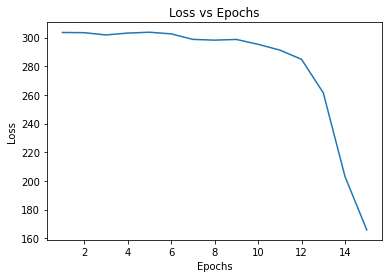

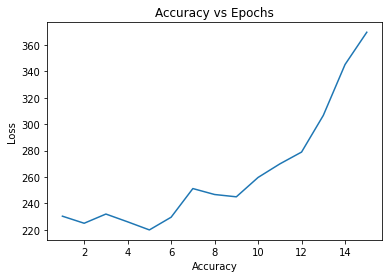

Validation Accuracy: 70.0000%


In [ ]:
import torch
from torchtext import data
from torchtext import datasets
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


tokens = data.Field(tokenize = 'spacy', include_lengths= True)

LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(tokens, LABEL)
train_data, valid_data = train_data.split()

tokens.build_vocab(train_data, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

BATCH_SIZE = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE,sort_within_batch = True, device = device)

vocab_size = len(tokens.vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 4
dropout = 0.5
epochs = 15

class SeqModel(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)       
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional= True, dropout=dropout)        
        self.fc = nn.Linear(hidden_dim * 4, output_dim)       
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, embedded_sentence_lengths):
        
        embedded = self.embedding(text)
        (enc_output) = self.rnn(embedded)
        all_hidden = enc_output[0]
        final_hidden = self.dropout(torch.cat((all_hidden[-2,:,:], all_hidden[-1,:,:]), dim = 1))     
        linear_mapped_representation = self.fc(final_hidden)
        return linear_mapped_representation

model = SeqModel().cuda()

pretrained_embeddings = tokens.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().cuda()

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

epoch_array = np.arange(1,epochs+1)
cost_array = []
acc_array = []

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0   
    model.train()
    for batch in iterator:        
        optimizer.zero_grad()
        text,text_length = batch.text
        predictions = model(text,text_length).squeeze(1)        
        loss = criterion(predictions, batch.label)       
        acc = binary_accuracy(predictions, batch.label)        
        loss.backward()
        optimizer.step()        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    cost_array.append(epoch_loss)
    acc_array.append(epoch_acc)
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

for epoch in range(epochs):
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epoch_array,cost_array)
plt.show()

plt.title("Accuracy vs Epochs")
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.plot(epoch_array,acc_array)
plt.show()

for batch in valid_iterator:
  text,text_length = batch.text
  pred = model(text,text_length).squeeze(1)
  acc = binary_accuracy(pred,batch.label)
print("Validation Accuracy: {:.4%}".format(acc))
